In [1]:
# Plotting Libraries and default stuff
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

# Pyswmm engine with ICC 
from pyswmm_lite import Env

# Bayesian Optimization
from GPyOpt.methods import BayesianOptimization
import tslearn.metrics as ts

In [2]:
def run_swmm(valve_set1, valve_set2, flow):
    env = Env("./networks/parallel.inp")

    data = {}
    data["endflow"] = []
    data["overflow1"]  = []
    data["overflow2"]  = []
    done = False
    for time in range(0, len(flow)):
        # set the gate_position 
        env.set_gate("1", valve_set1)
        env.set_gate("2", valve_set2)

        env.sim._model.setNodeInflow("P1", 3*flow[time])
        env.sim._model.setNodeInflow("P2", 3*flow[time])


        # record_data
        data["endflow"].append(env.flow("8"))
        data["overflow1"].append(env.sim._model.getNodeResult("P1", 4))
        data["overflow2"].append(env.sim._model.getNodeResult("P2", 4))

        # step through simulation
        done = env.step()

    return data["endflow"], sum(data["overflow1"]), sum(data["overflow2"])

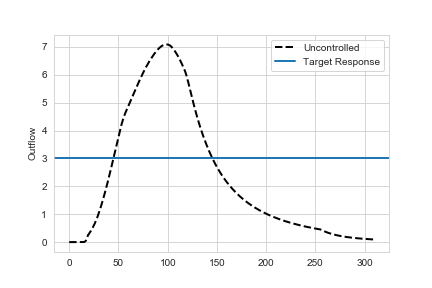

In [3]:
## Let us generate synth flows 
flow = np.sin(np.linspace(0.0, 1.0, 100)*np.pi) * 2.0 # Half sine wave
flow = np.hstack((np.zeros(10), flow, np.zeros(200)))

# Both the ponds in the system receive the same flow 
outflow, _, _ = run_swmm(1.0, 1.0, flow)

target = 3.0
plt.plot(outflow, "k--", linewidth=2.0, label="Uncontrolled")
plt.axhline(target,  linewidth=2.0, label="Target Response")
plt.ylabel("Outflow")
plt.legend()

In [4]:
data_s = {}

for i in [5, 10, 15, 20, 50, 75]:
    data_s[str(i)] = {}
    for j in range(0,10):
        def fc(x):
            pred_flow, d1, d2 = run_swmm(x[0][0], x[0][1], flow)
            pred_flow = np.asarray(pred_flow)
            pred_flow[pred_flow <= 4.0] = 0.0
            pred_flow[pred_flow > 4.0] = 1.0
            distance = pred_flow.sum()
            loss = distance + (d1 + d2)*10.0
            return loss

        # Define gpopt
        domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
                  {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)}]

        # --- Solve your problem
        myBopt = BayesianOptimization(f=fc,
                domain=domain,
                model_type = 'GP',
                acquisition_type='EI',
                exact_feval = True,
                acquisition_weight = 2)

        myBopt.run_optimization(max_iter=i)

        data_c, ov1, ov2 = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], flow)
        data_s[str(i)][str(j)+"flow"] = data_c
        data_s[str(i)][str(j)+"overflow"] = ov1+ov2

In [7]:
def performance(flow, threshold=4.0):
    exced_flow = [i if i > threshold else 0.0 for i in flow]
    return sum(exced_flow)

pref = []
for i in [25, 50, 75]:
    ar = []
    for j in range(0, 5):
        ar.append(performance(data_s[str(i)][str(j)+"flow"]))
    pref.append(ar)

<IPython.core.display.Javascript object>


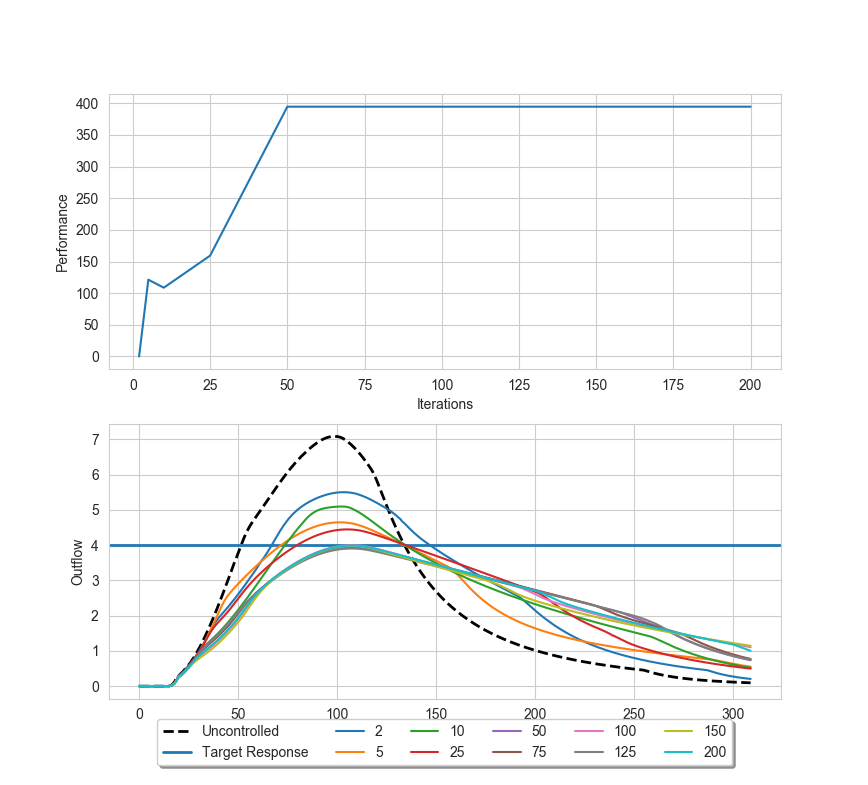

In [43]:
plt.subplot(2,1,1)
plt.plot([2, 5, 10, 25, 50, 75, 100, 125, 150, 200], perf_inv)
plt.ylabel("Performance")
plt.xlabel("Iterations")

plt.subplot(2,1,2)
plt.plot(outflow, "k--", linewidth=2.0, label="Uncontrolled")
plt.axhline(4.0,  linewidth=2.0, label="Target Response")
for i in [2, 5, 10, 25, 50, 75, 100, 125, 150, 200]:
    plt.plot(data_sim[str(i)+"flow"], label=str(i))
plt.ylabel("Outflow")
plt.xlabel("Time")
plt.legend()
# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=6)

<IPython.core.display.Javascript object>


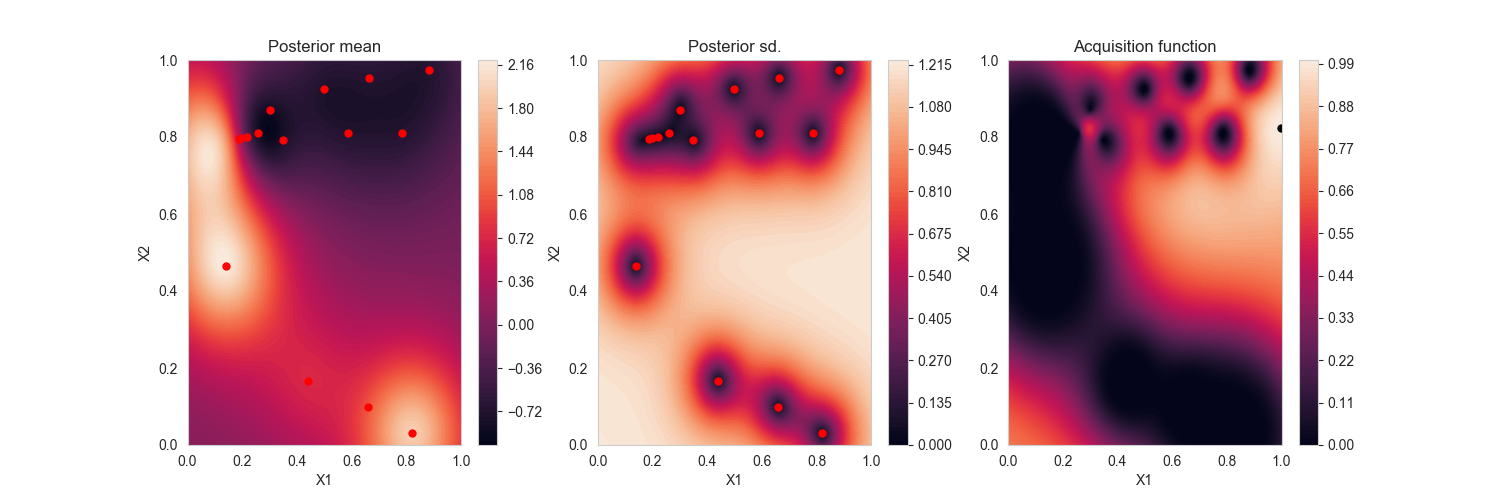

In [44]:
    def fc(x):
        pred_flow, d1, d2 = run_swmm(x[0][0], x[0][1], flow)
        pred_flow = np.asarray(pred_flow)
        pred_flow[pred_flow <= 4.0] = 0.0
        pred_flow[pred_flow > 4.0] = 1.0
        distance = pred_flow.sum()
        loss = distance + (d1 + d2)*10.0
        return loss

    # Define gpopt
    domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
              {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)}]

    # --- Solve your problem
    myBopt = BayesianOptimization(f=fc,
            domain=domain,
            model_type = 'GP',
            acquisition_type='EI',
            exact_feval = True,
            acquisition_weight = 2)

    myBopt.run_optimization(max_iter=10)

    data_c, ov1, ov2 = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], flow)
    myBopt.plot_acquisition()

In [8]:
ar

[0.0, 0.0, 0.0, 0.0, 0.0]

In [9]:
pref

[[0.0, 255.49962029838233, 0.0, 217.09535493455846, 0.0],
 [0.0, 0.0, 48.21425985804619, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

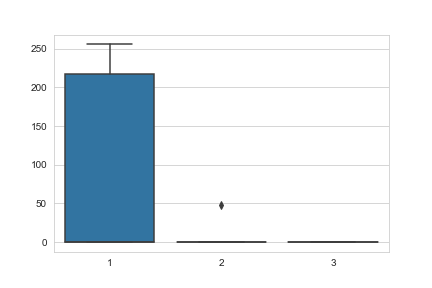

In [13]:
sns.boxplot([1,2,3], pref)